# Practical Work 4 - Autoencoder
# Question 3 : Denoising autoencoder

## Introduction

Main goal: build an denoising autoencoder using Keras
- noisy the input;
- the output is the noiseless image;
- using Sequential mode.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as tk
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

## MNIST dataset loading
The MNIST data is loaded. The parameters of the database are retrieved (number of examples, of classes, size of the retina)

Remark : The MNIST (Mixed National Institute of Standards and Technology) database is a database of handwritten numbers. It is a standard database for testing new algorithms for recognizing these digits. It consists of 60000 training images and 10000 test images. Grayscale images are normalized and centered with the size of 28 pixels and 28 pixels.


The MNIST data is then loaded. The parameters of the database are retrieved (number of examples, of classes, size of the retina).
The training dataset is processed by added a noise.

11493376/11490434 [==============================] - 0s 0us/step
Size of the retina :  784
Number of samples  :  60000


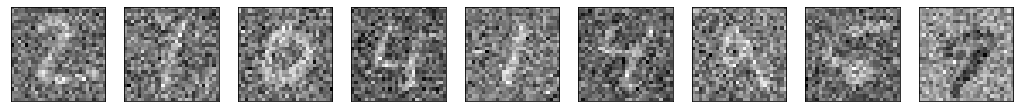

In [2]:
# MNIST dataset loading
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Number of samples in the training dataset
num_examples = x_train.shape[0] 
# Number of samples in the test dataset
num_test = x_test.shape[0]
# Size of the input layer (retina) = number of pixels of the MNIST images (784 pixels)
num_input = x_train.shape[1]*x_train.shape[2]
# Number of classes ( the 10 digits : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})
num_classes = 10

# Width ( and height) of the images
img_size = x_train.shape[1] 
# Size of (square) image
img_shape = (img_size, img_size)

# Reshape of datatsets in array and normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), img_size, img_size, 1))
x_test = np.reshape(x_test, (len(x_test), img_size, img_size, 1))

# Print
print('Size of the retina : ',num_input)
print("Number of samples  : ",num_examples)

# Add noise on training dataset
noise = 0.5
x_train_noised = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noised  = x_test  + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# Print the training dataset
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_noised[i].reshape(img_size, img_size), cmap="binary")
plt.show()

## Construction of the model (Convolutionnal Neural Network based Autoencoder)
### Global parameters of the algorithm

In [3]:
# Parameters of the algorithm
lr = 0.001
num_epochs = 5
batch_size = 256

### Definition of the autoencoder model
** CONV - MAX POOLING - CONV - MAX POOLING - CONV - UPSAMPLING - CONV - UPSAMPLING - CONV **

In [4]:
model = tk.models.Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_size,img_size,1)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
          
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3), activation='sigmoid', padding='same'))

### Model construction (loss function & optimization prodedure)


In [10]:
adam = Adam(lr)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

### Learning and test

Epoch 1/5
235/235 [==============================] - 3s 10ms/step - loss: 0.8239 - acc: 0.8052 - val_loss: 0.1289 - val_acc: 0.8082
Epoch 2/5
235/235 [==============================] - 2s 10ms/step - loss: 0.1250 - acc: 0.8095 - val_loss: 0.1138 - val_acc: 0.8103

Epoch 0 Accuracy :0.810 


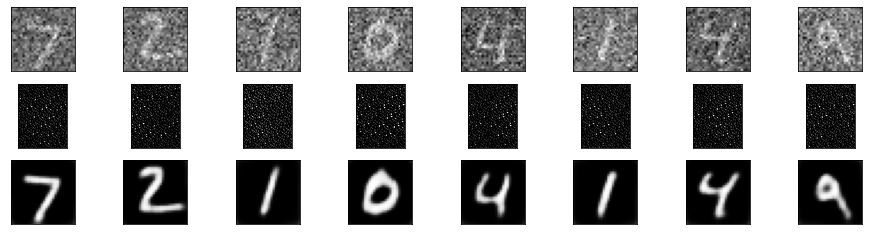

Epoch 3/5
235/235 [==============================] - 2s 10ms/step - loss: 0.1132 - acc: 0.8111 - val_loss: 0.1080 - val_acc: 0.8108
Epoch 4/5
235/235 [==============================] - 2s 10ms/step - loss: 0.1081 - acc: 0.8118 - val_loss: 0.1050 - val_acc: 0.8115

Epoch 2 Accuracy :0.812 


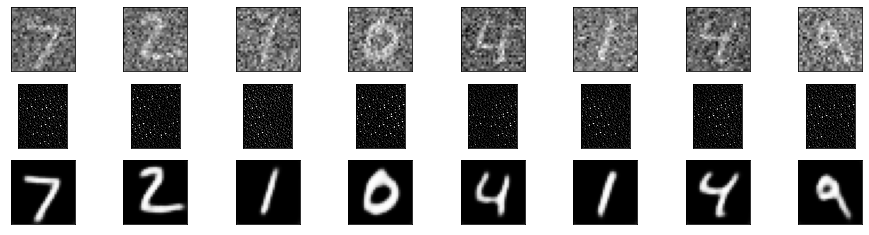

Epoch 5/5
235/235 [==============================] - 2s 10ms/step - loss: 0.1054 - acc: 0.8123 - val_loss: 0.1031 - val_acc: 0.8115


In [11]:
class myCallback(tk.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        encoder = K.function([model.layers[0].input],[model.layers[3].output])
        if((epoch-1) % 2==0):   
            print("\nEpoch {0:d} Accuracy :{1:5.3f} ".format(epoch-1,logs.get('acc') ))
            decoded_imgs = model.predict(x_test)
            encoded_imgs = encoder([x_test_noised])[0]

            n = 8  
            plt.figure(figsize=(40, 4))
            for i in range(n):
                ax = plt.subplot(3, 20, i + 1)
                plt.imshow(x_test_noised[i].reshape(img_size, img_size))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(3, 20, i + 1 + 20)
                plt.imshow(encoded_imgs[i].reshape(64,49))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(3, 20, 2*20 +i+ 1)
                plt.imshow(decoded_imgs[i].reshape(img_size, img_size))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            plt.show()

            
callbacks = myCallback()
model.fit(x_train_noised,x_train,epochs=num_epochs,batch_size=batch_size,validation_data=(x_test_noised, x_test),callbacks=[callbacks])


### Test : prediction
 - evaluate : [Returns the loss value & metrics values for the model in test mode](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate).

In [12]:
model.evaluate(x_test_noised, x_test)


313/313 [==============================] - 1s 2ms/step - loss: 0.1031 - acc: 0.8115


[0.1030503660440445, 0.8114761710166931]

### Test : print the denoised images
 - predict : [Generates output predictions for the input samples](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

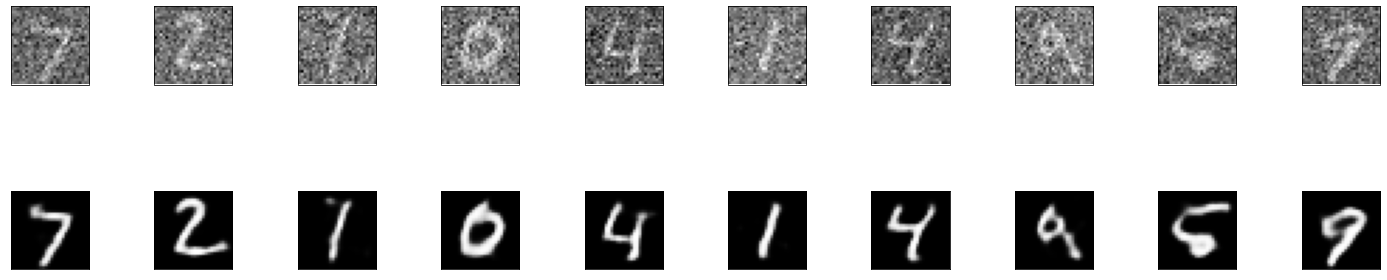

In [13]:
denoised_img = model.predict(x_test_noised)
plt.figure(figsize=(40, 4))
for i in range(10):
    ax = plt.subplot(3, 20, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_noised[i].reshape(img_size, img_size))
    
    ax = plt.subplot(3, 20, 40 +i+ 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(denoised_img[i].reshape(img_size, img_size))

plt.tight_layout()